In [ ]:
#!pip install transformers

#!pip install torch

#!pip install torch==1.13.1

#!pip install datasets

#!pip install clip

In [ ]:
import os
import torch
import skimage
import requests
import numpy as np
import pandas as pd
from PIL import Image
from io import BytesIO
import IPython.display
import matplotlib.pyplot as plt
from datasets import load_dataset
from collections import OrderedDict
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizer
import json
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import clip
import zipfile

Load the csv file containing selected articles

In [ ]:
articles=pd.read_csv('selected_articles.csv',index_col=0)

In [ ]:
# Adding the missing 0 to the article id and converting it to string as per the original dataset
articles['article_id'] = articles['article_id'].astype(str)
articles['article_id']=["0"+x for x in articles['article_id']]

In [ ]:
df = articles[['article_id','caption']]

Get the image path corresponding to each article id from zipped folders. We're adding the paths to the dataframe in a separate column.
This will be used later to load the images during model training

In [ ]:
z1 = zipfile.ZipFile('H&M_dataset/selected_images_1.zip')
files_in_zip_1 = z1.namelist()

In [ ]:
id_to_path_mapping = {file.split('/')[1].split('.')[0]: file for file in files_in_zip_1}
df['image_path'] = df['article_id'].map(id_to_path_mapping)

del id_to_path_mapping

Remove missing values

In [ ]:
df = df.dropna()

Splitting into train, validation and test datasets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['image_path'], df['caption'], test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

train_data = pd.DataFrame({'image_path':X_train.values, 'caption': y_train.values})
val_data = pd.DataFrame({'image_path':X_val.values, 'caption': y_val.values})
test_data = pd.DataFrame({'image_path':X_test.values, 'caption': y_test.values})

Here we define a few functions and a class to load the CLIP model and prepare the dataset

In [ ]:
# Function to get CLIP model, processor and tokenizer
def get_model_info(model_ID, device):

    model = CLIPModel.from_pretrained(model_ID).to(device)
    processor = CLIPProcessor.from_pretrained(model_ID)
    tokenizer = CLIPTokenizer.from_pretrained(model_ID)

    return model, processor, tokenizer

In [ ]:
# Function to convert model's parameters to FP32 format
def convert_models_to_fp32(model):

    for p in model.parameters():
        p.data = p.data.float()
        p.grad.data = p.grad.data.float()

In [ ]:
# Function to extract images from the given image path and store them as PIL objects
def get_image(image_path):
    if image_path in z1.namelist():
        image = Image.open(BytesIO(z1.read(image_path))).convert("RGB")

    return image

In [ ]:
# Defining a class to prepare dataset for batch processing
class image_title_dataset():
    def __init__(self, list_image_path,list_txt):

        self.image_path = list_image_path
        self.title  = list_txt

    def __len__(self):
        return len(self.title)

    def __getitem__(self, idx):

        return self.image_path[idx], self.title[idx]

Prepare the dataset and create batches

In [ ]:
list_image_path_train = []
list_txt_train = []
list_image_path_val = []
list_txt_val = []

for index,item in train_data.iterrows():
    # Taking first 2000 image caption pairs from train data
    if index==2000:
        break
    img_path = item['image_path']
    caption = item['caption'][:77]
    list_image_path_train.append(img_path)
    list_txt_train.append(caption)

for index,item in val_data.iterrows():
  # Taking first 1000 image caption pairs from validation data
    if index==1000:
        break
    img_path = item['image_path']
    caption = item['caption'][:77]
    list_image_path_val.append(img_path)
    list_txt_val.append(caption)


train_dataset = image_title_dataset(list_image_path_train, list_txt_train)
val_dataset = image_title_dataset(list_image_path_val, list_txt_val)

train_dataloader = DataLoader(train_dataset, batch_size=200, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=100, shuffle=True)

Load CLIP model and set model parameters

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_ID = "openai/clip-vit-base-patch32"

model, processor, tokenizer = get_model_info(model_ID, device)

if device == "cpu":
    model.float()

optimizer = torch.optim.Adam(model.parameters(), lr=5e-5,betas=(0.9,0.98),eps=1e-6,weight_decay=0.2) # the lr is smaller, more safe for fine tuning to new dataset

loss_img = nn.CrossEntropyLoss()
loss_txt = nn.CrossEntropyLoss()

Model finetuning on train data and evaluation on validation data

In [ ]:
num_epochs = 3
train_loss_per_epoch=[]
val_loss_per_epoch=[]


for epoch in range(num_epochs):

    # Finetuning on train data
    train_losses=0

    with tqdm(total=len(train_dataloader), desc=f'Epoch {epoch + 1} - Training') as pbar_train:

        # Processing for each train batch
        for images, texts in train_dataloader:
            optimizer.zero_grad()

            # Load images from image paths
            image_list=[get_image(img) for img in images]

            # Encode the images and texts using CLIP's processor
            inputs = processor(text=texts, images=image_list, return_tensors="pt", padding=True)
            inputs=inputs.to(device)

            # Get image and text embeddings using CLIP model
            outputs = model(**inputs)

            # Get similarity scores between the image-text embeddings
            logits_per_image, logits_per_text = outputs.logits_per_image, outputs.logits_per_text

            # Compute loss
            ground_truth = torch.arange(len(images),dtype=torch.long,device=device)
            total_loss = (loss_img(logits_per_image,ground_truth) + loss_txt(logits_per_text,ground_truth))/2

            # Perform backward pass
            total_loss.backward()
            if device == "cpu":
                optimizer.step()

            else :
                convert_models_to_fp32(model)
                optimizer.step()
                #clip.model.convert_weights(model)

            train_losses += total_loss.item()
            pbar_train.update(1)

        # Get final train loss for the epoch
        final_train_loss=train_losses/len(train_dataloader)


    # Evaluating on validation data - same as above but without any parameter updates
    val_losses=0

    with torch.no_grad():
        with tqdm(total=len(val_dataloader), desc=f'Epoch {epoch + 1} - Validation') as pbar_val:
            for images, texts in val_dataloader:

                image_list=[get_image(img) for img in images]
                inputs = processor(text=texts, images=image_list, return_tensors="pt", padding=True)

                inputs=inputs.to(device)
                outputs = model(**inputs)
                logits_per_image, logits_per_text = outputs.logits_per_image, outputs.logits_per_text

                ground_truth = torch.arange(len(images),dtype=torch.long,device=device)
                total_loss = (loss_img(logits_per_image,ground_truth) + loss_txt(logits_per_text,ground_truth))/2

                val_losses += total_loss.item()
                pbar_val.update(1)

            # Get final validation loss for the epoch
            final_val_loss=val_losses/len(val_dataloader)

    # Print the losses
    print(f'Epoch {epoch + 1} - Train Loss: {final_train_loss:.4f}, Validation Loss: {final_val_loss:.4f}')
    train_loss_per_epoch.append(final_train_loss)
    val_loss_per_epoch.append(final_val_loss)

Epoch 1 - Validation: 100%|██████████| 10/10 [08:41<00:00, 52.13s/it]


Epoch 1 - Train Loss: 3.4947, Validation Loss: 2.2920


Epoch 2 - Validation: 100%|██████████| 10/10 [08:48<00:00, 52.84s/it]


Epoch 2 - Train Loss: 2.3198, Validation Loss: 1.4726


Epoch 3 - Validation: 100%|██████████| 10/10 [08:37<00:00, 51.73s/it]

Epoch 3 - Train Loss: 1.5557, Validation Loss: 1.1873


Plot train and validation losses

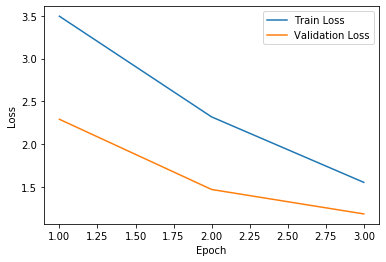

In [ ]:
plt.plot(range(1, num_epochs+1), train_loss_per_epoch, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_loss_per_epoch, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Example usage of get_image()
id_to_image_mapping = {img_path.split('/')[1].split('.')[0]: get_image(img_path) for img_path in df['image_path']}
df['image'] = df['article_id'].map(id_to_image_mapping)

del id_to_image_mapping

In [ ]:
df

,article_id,caption,image_path,image
0,0108775015,"womens Solid Black Vest top, Jersey top with n...",selected_images_1/0108775015.jpg,<PIL.Image.Image image mode=RGB size=1166x1750...
1,0108775044,"womens Solid White Vest top, Jersey top with n...",selected_images_1/0108775044.jpg,<PIL.Image.Image image mode=RGB size=1166x1750...
2,0108775051,"womens Stripe Off White Vest top, Jersey top w...",selected_images_1/0108775051.jpg,<PIL.Image.Image image mode=RGB size=1166x1750...
3,0111586001,"womens Solid Black Leggings, Tights with built...",selected_images_1/0111586001.jpg,<PIL.Image.Image image mode=RGB size=1166x1750...
6,0116379047,"womens Solid Dark Blue Top, Fitted top in soft...",selected_images_1/0116379047.jpg,<PIL.Image.Image image mode=RGB size=1531x1750...
...,...,...,...,...
42236,0704630002,"womens Solid Light Orange Sneakers, Trainers w...",selected_images_1/0704630002.jpg,<PIL.Image.Image image mode=RGB size=1166x1750...
42237,0704630003,"womens Colour blocking White Sneakers, Trainer...",selected_images_1/0704630003.jpg,<PIL.Image.Image image mode=RGB size=1166x1750...
42238,0704630004,"womens Colour blocking Black Sneakers, Trainer...",selected_images_1/0704630004.jpg,<PIL.Image.Image image mode=RGB size=1166x1750...
42239,0704630005,"womens Colour blocking Orange Sneakers, Traine...",selected_images_1/0704630005.jpg,<PIL.Image.Image image mode=RGB size=1166x1750...
